In [27]:
import numpy as np
import pandas as pd
import re
import pickle
import itertools
from __future__ import print_function
from __future__ import division
import matplotlib.pyplot as plt
from collections import Counter
import matplotlib.pyplot as plt
import csv
from datetime import datetime


# SK-learn libraries for learning.
#from sklearn.pipeline import Pipeline
#from sklearn.grid_search import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import SGDClassifier

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

# NLTK libs
from nltk.tokenize import TweetTokenizer

import dask.dataframe as dd

In [2]:
file_list = [
'01openjobs-jobpostings.mar-2016.csv',
'02openjobs-jobpostings.apr-2016.csv',
'03openjobs-jobpostings.may-2016.csv',
'04openjobs-jobpostings.jun-2016.csv',
'05openjobs-jobpostings.jul-2016.csv',
'06openjobs-jobpostings.aug-2016.csv',
'07openjobs-jobpostings.sep-2016.csv',
'08openjobs-jobpostings.oct-2016.csv',
'09openjobs-jobpostings.nov-2016.csv',
'10openjobs-jobpostings.dec-2016.csv',
'11openjobs-jobpostings.jan-2017.csv',
'12openjobs-jobpostings.feb-2017.csv',
'13openjobs-jobpostings.mar-2017.csv',
'14openjobs-jobpostings.apr-2017.csv',
'15openjobs-jobpostings.may-2017.csv',
'16openjobs-jobpostings.jun-2017.csv',
'17openjobs-jobpostings.jul-2017.csv']

In [3]:
df = pd.DataFrame()
for filename in file_list:
    data = pd.read_csv(filename)
    df = df.append(data)

In [4]:
df.count()

Unnamed: 0          846613
datePosted          846613
organizationName    843930
title               846609
onetName            705218
onetCode            705218
numberOfOpenings    846613
medianSalary        846613
jobDescription      846607
locality            771794
region              761879
dtype: int64

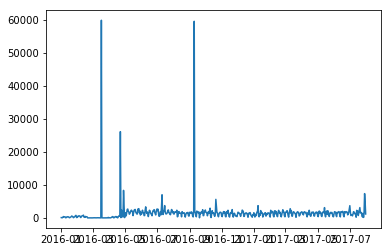

In [5]:
df['datePosted'] = df.datePosted.map(lambda x: pd.to_datetime(x))

cnt_timeline = df[df.datePosted >= '2016-01-01']
cnt_timeline = cnt_timeline.groupby('datePosted').title.count().reset_index()

plt.plot(cnt_timeline.datePosted,cnt_timeline.title)
plt.show()

In [6]:
df.datePosted.min()

Timestamp('2010-10-31 00:00:00')

In [7]:
df.groupby('datePosted').title.count().reset_index().sort_values(by='title',ascending=False).head()

,datePosted,title
302,2016-03-17,59837
478,2016-09-09,59516
338,2016-04-22,26116
344,2016-04-28,8341
795,2017-07-29,7363


In [8]:
df[df.datePosted == '2016-03-17'].groupby('organizationName').title.count()\
    .reset_index().sort_values(by='title',ascending=False).head()

,organizationName,title
1116,Oracle,5299
1337,Sentara Health,1189
223,Booz Allen Hamilton,1133
1176,Pizza Hut,1090
285,CVS Health,1068


In [9]:
df[(df.organizationName == 'Oracle') & (df.datePosted == '2016-03-17')].groupby('title').datePosted.count()\
    .reset_index().sort_values(by='datePosted', ascending=False).head()

,title,datePosted
20,Applications Sales Representative III,215
297,Principal Sales Consultant,207
25,Applications Sales Representative V,180
68,CRM Applications Sales Rep,150
398,Senior Principal Consultant,130


In [10]:
df[(df.organizationName == 'Oracle') & (df.title == 'Applications Sales Representative IV')].to_csv('temp.csv')

In [11]:
df.groupby('onetCode').title.count().reset_index().sort_values(by='title',ascending=False).head()

,onetCode,title
1,11-1021.00,88634
51,13-1111.00,45099
484,53-3032.00,36853
92,15-1151.00,29726
85,15-1132.00,28591


In [12]:
occupation_data = pd.read_csv('job_types/db_22_2_excel/occupation_data.csv')
occupation_data.head()

,onetCode,onet_title,onet_description
0,11-1011.00,Chief Executives,Determine and formulate policies and provide o...
1,11-1011.03,Chief Sustainability Officers,"Communicate and coordinate with management, sh..."
2,11-1021.00,General and Operations Managers,"Plan, direct, or coordinate the operations of ..."
3,11-1031.00,Legislators,"Develop, introduce or enact laws and statutes ..."
4,11-2011.00,Advertising and Promotions Managers,"Plan, direct, or coordinate advertising polici..."


In [13]:
# df.set_index('onetCode',inplace=True)
# occupation_data.set_index('onet',inplace=True)

In [14]:
combined_df = dd.merge(df, occupation_data, how='outer', on=['onetCode'])

In [15]:
combined_df.groupby(['onet_title','onetCode'])['datePosted'].count().reset_index()\
    .sort_values(by='datePosted',ascending=False).to_csv('temp.csv')

In [16]:
# combined_df[combined_df.onet_title == 'Management Analysts'].to_csv('temp2.csv')

In [22]:
data = combined_df[(combined_df.onet_title == 'Computer User Support Specialists') |
            (combined_df.onet_title == 'Software Developers, Applications') |
            (combined_df.onet_title == 'Mechanical Engineers') |
            (combined_df.onet_title == 'Registered Nurses')
           ]

In [24]:
data.groupby('onet_title')['title'].count()

onet_title
Computer User Support Specialists    29726
Mechanical Engineers                 23883
Registered Nurses                    22234
Software Developers, Applications    28591
Name: title, dtype: int64

# Data Processing

In [25]:
# Borrowed some functions from the w266 utils.py file
# Miscellaneous helpers
def flatten(list_of_lists):
    """Flatten a list-of-lists into a single list."""
    return list(itertools.chain.from_iterable(list_of_lists))


# Word processing functions
def canonicalize_digits(word):
    if any([c.isalpha() for c in word]): return word
    word = re.sub("\d", "DG", word)
    if word.startswith("DG"):
        word = word.replace(",", "") # remove thousands separator
    return word

def canonicalize_word(word, wordset=None, digits=True):
    word = re.sub(r"(https?:\/\/)?([\da-z\.-]+)\.([a-z\.]{2,6})([\/\w\.-]*)*\/?\S*", "postedhyperlinkvalue", word)
    word = re.sub(r"(postedhyperlinkvalue)+", "postedhyperlinkvalue", word)
    #if not word.isupper():
    word = word.lower()
    if digits:
        if (wordset != None) and (word in wordset): return word
        word = canonicalize_digits(word) # try to canonicalize numbers
    if (wordset == None) or (word in wordset):
        return word
    else:
        return constants.UNK_TOKEN

def canonicalize_words(words, **kw):
    return [canonicalize_word(word, **kw) for word in words]

In [50]:
def make_data(data, target, tokenizer=TweetTokenizer(), canonize=True, stem=True):
        
    # Separate comments
    comments = data.loc[:, 'jobDescription']
    labels = data.loc[:, target]
    
    # Convert to list
    comment_list = comments.values.tolist()
    
    # Tokenize comments
    tokenizer = tokenizer
    x_tokens = [tokenizer.tokenize(sentence) for sentence in comment_list]

    from nltk.stem import PorterStemmer
    ps = PorterStemmer()

    if stem:
        if canonize:
            comments_canon = []
            for token in x_tokens:
                stem_token = []
                for word in token:
                    stem_token.append(ps.stem(word))
                x_tokens_canon = canonicalize_words(stem_token)
                comments_canon.append(x_tokens_canon)
            x_tokens = comments_canon
        
    if not stem:
        if canonize:
            comments_canon = []
            for token in x_tokens:
                x_tokens_canon = canonicalize_words(token)
                comments_canon.append(x_tokens_canon)
            x_tokens = comments_canon
        
    return comments, x_tokens, labels

In [51]:
data = data[~data.jobDescription.isnull()]

In [45]:
# tokenizer = TweetTokenizer()
# x_tokens = [tokenizer.tokenize(sentence) for sentence in comment_list]

In [52]:
comments, x_tokens, labels = \
make_data(data, target='onet_title',stem=False )

In [54]:
# Split into test and train
train_data, test_data, train_labels, test_labels = \
    train_test_split(x_tokens, labels, test_size=0.10, random_state=42)  

In [55]:
# Count or TF-IDF vectorize, removing stop words.
vectorizer = TfidfVectorizer(analyzer='word', stop_words='english', lowercase=False, 
                             tokenizer=lambda text: text)
                             #tokenizer=lambda text: text, min_df=0.00002, max_df=0.005)

In [56]:
train_data_sparse = vectorizer.fit_transform(train_data)
test_data_sparse = vectorizer.transform(test_data)

/Users/kwheatley/anaconda/envs/python36/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


In [57]:
# Save off word counts in csv
flat_list = [item for sublist in x_tokens for item in sublist]
counts = Counter(flat_list)

with open('dict.csv', 'w') as csv_file:
    writer = csv.writer(csv_file)
    for key, value in counts.items():
       writer.writerow([key, value])

In [58]:
counts = {}
for label in np.unique(labels):
    counts[label] = sum(labels == label)

print("Class counts:\n{}".format(counts))

Class counts:
{'Computer User Support Specialists': 29726, 'Mechanical Engineers': 23883, 'Registered Nurses': 22234, 'Software Developers, Applications': 28591}


# Logistic Regresssion

In [59]:
lgst_l1 = SGDClassifier(loss="log", penalty="l1", random_state=42
#                         ,alpha=0.00015
                       )
lgst_l1.fit(train_data_sparse, train_labels)
# save the classifier
# with open('lgst_l1_classifier.pkl', 'wb') as fid:
#     pickle.dump(lgst_l1, fid)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', n_iter=5, n_jobs=1,
       penalty='l1', power_t=0.5, random_state=42, shuffle=True, verbose=0,
       warm_start=False)

In [60]:
#Create predictions and evaluate
pred_labels = lgst_l1.predict(test_data_sparse)
print("Training set score: {:.3f}".format(lgst_l1.score(train_data_sparse, train_labels)))
print("Test set score: {:.3f}".format(lgst_l1.score(test_data_sparse, test_labels)))
print("Number of features used: {}".format(np.sum(lgst_l1.coef_ != 0)))

print("Confusion Matrix...")
confusionMatrix = metrics.confusion_matrix(test_labels, pred_labels)
print(confusionMatrix)

Training set score: 0.928
Test set score: 0.926
Number of features used: 587
Confusion Matrix...
[[2901   56   15   40]
 [  72 2116    0  235]
 [  19    0 2237    0]
 [ 106  226    1 2420]]


In [61]:
from sklearn.datasets import make_classification
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

print("f1_score ", f1_score(test_labels, pred_labels, average="macro"))
print("precision_score", precision_score(test_labels, pred_labels, average="macro"))
print("recall", recall_score(test_labels, pred_labels, average="macro"))   

f1_score  0.9270135427990355
precision_score 0.9274175326406364
recall 0.9267660089191299


/Users/kwheatley/anaconda/envs/python36/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [63]:
print(classification_report(test_labels, pred_labels))

                                   precision    recall  f1-score   support

Computer User Support Specialists       0.94      0.96      0.95      3012
             Mechanical Engineers       0.88      0.87      0.88      2423
                Registered Nurses       0.99      0.99      0.99      2256
Software Developers, Applications       0.90      0.88      0.89      2753

                      avg / total       0.93      0.93      0.93     10444



In [64]:
n=20
prediction_probs = lgst_l1.predict_proba(test_data_sparse)[:,0]
prob_actual = list(zip(prediction_probs, pred_labels,test_data))

print("Most likely fans")
for row in sorted(prob_actual)[:n]:
    print(row)
print()

print("Least likely fans")
for row in sorted(prob_actual)[-n:]:
    print(row)
print()

Most likely fans
(4.395029247580342e-07, 'Registered Nurses', ['tracking', 'code', '.', 'DGDGDGDGDG', '.', 'job', 'description', '.', 'i', 'believe', 'that', 'the', 'care', 'we', 'give', 'can', 'make', 'every', 'moment', 'count', '.', 'compassionate', 'care', ',', 'uncompromising', 'service', 'and', 'clinical', 'excellence', '-', "that's", '.', 'how', 'our', 'hospice', 'improves', 'quality', 'of', 'life', 'in', 'the', 'final', 'stages', 'of', 'life', '.', 'by', '.', 'delivering', 'palliative', 'care', 'by', 'hospice', 'professionals', ',', 'our', 'patients', 'can', 'spend', '.', 'their', 'remaining', 'days', 'in', 'comfort', 'and', 'peace', '.', 'kindred', 'at', 'home', ',', 'a', 'division', 'of', '.', 'kindred', 'healthcare', 'inc', '.', ',', 'is', 'the', "nation's", 'leading', 'provider', 'of', 'comprehensive', '.', 'home', 'health', ',', 'hospice', ',', 'and', 'non-medical', 'home', 'care', 'services', '.', 'kindred', 'at', 'home', ',', 'and', 'its', 'affiliates', ',', 'including', 

In [81]:
n=50
classifier=lgst_l1

feature_names = vectorizer.get_feature_names()
    
topn_class1 = sorted(zip(classifier.coef_[0], feature_names))[:n]
topn_class2 = sorted(zip(classifier.coef_[0], feature_names))[-n:]
# for coef, feat in topn_class1:
#     print (round(coef,2), feat)

# print()

for coef, feat in reversed(topn_class2):
    print (round(coef,2), feat)

68.86 specialist
8.25 hardware
6.87 desk
6.21 office
5.16 technician
5.03 client
4.53 high
3.72 social
3.65 programs
3.64 service
3.57 announcement
3.41 special
3.27 information
3.26 position
3.15 training
3.06 diploma
3.05 operations
2.99 support
2.97 geek
2.94 squad
2.91 mason
2.8 order
2.79 store
2.77 resources
2.63 agency
2.22 computers
2.09 provides
1.92 technicians
1.9 center
1.85 required
1.7 users
1.66 level
1.64 administrative
1.6 prepare
1.56 specialists
1.51 a5
1.49 duties
1.45 z
1.33 procedures
1.29 maintains
1.18 /DG
1.15 human
1.04 specialized
0.99 international
0.95 acquisition
0.95 personnel
0.9 requests
0.89 operating
0.89 market
0.87 asset


In [82]:
n=50
classifier=lgst_l1

feature_names = vectorizer.get_feature_names()
    
topn_class1 = sorted(zip(classifier.coef_[1], feature_names))[:n]
topn_class2 = sorted(zip(classifier.coef_[1], feature_names))[-n:]
# for coef, feat in topn_class1:
#     print (round(coef,2), feat)

# print()

for coef, feat in reversed(topn_class2):
    print (round(coef,2), feat)

42.22 engineer
15.23 engineering
7.09 systems
5.7 test
5.61 network
5.56 mechanical
5.31 technical
4.55 engineers
3.29 construction
3.15 testing
2.91 analysis
2.82 platform
2.78 cisco
2.71 design
2.65 architecture
2.64 enterprise
2.29 strong
2.28 ip
2.25 cbre
2.2 tools
2.04 demonstrations
2.03 splunk
1.93 vmware
1.92 security
1.89 knowledge
1.85 communications
1.71 understanding
1.68 opower
1.65 energy
1.64 nextlabs
1.57 cyber
1.57 ground
1.56 cloud
1.55 travel
1.55 environments
1.51 itil
1.51 cybersecurity
1.51 designs
1.41 ships
1.31 water
1.3 amazon
1.26 windows
1.25 configuration
1.24 citizenship
1.17 algorithms
1.13 modeling
1.0 equipment
1.0 storage
0.98 aramark
0.94 field


In [83]:
n=50
classifier=lgst_l1

feature_names = vectorizer.get_feature_names()
    
topn_class1 = sorted(zip(classifier.coef_[2], feature_names))[:n]
topn_class2 = sorted(zip(classifier.coef_[2], feature_names))[-n:]
# for coef, feat in topn_class1:
#     print (round(coef,2), feat)

# print()

for coef, feat in reversed(topn_class2):
    print (round(coef,2), feat)

31.56 nurse
18.74 nursing
13.72 rn
13.67 care
8.05 registered
5.97 lrb-rn-rrb
5.63 healthcare
5.63 hospital
5.57 patient
4.8 residents
4.72 health
4.68 bed
3.95 medical
3.87 carilion
3.7 facility
3.05 temporary
2.96 patients
2.66 clinic
2.43 specialty
2.31 virginia
1.74 DGDGDG
1.63 reference
1.42 randstad
1.4 license
1.33 roanoke
1.05 clinical
0.85 state
0.51 licensure
0.48 washington
0.41 located
0.3 bls
0.26 surgical
0.23 acls
0.21 apply
0.14 fredericksburg
0.13 miles
0.0 �
0.0 ~
0.0 |
0.0 zytel-lrb-r-rrb
0.0 zynq
0.0 zweimiller
0.0 zweig
0.0 zwe
0.0 zwada
0.0 zvm
0.0 zuul
0.0 zuse
0.0 zurb
0.0 zuni


In [84]:
n=50
classifier=lgst_l1

feature_names = vectorizer.get_feature_names()
    
topn_class1 = sorted(zip(classifier.coef_[3], feature_names))[:n]
topn_class2 = sorted(zip(classifier.coef_[3], feature_names))[-n:]
# for coef, feat in topn_class1:
#     print (round(coef,2), feat)

# print()

for coef, feat in reversed(topn_class2):
    print (round(coef,2), feat)

36.06 developer
16.24 software
8.28 development
7.95 java
7.84 oracle
6.98 programming
5.11 months
4.7 solutions
4.41 accounts
4.23 sql
3.91 business
3.4 applications
3.35 integration
2.99 agile
2.85 capital
2.8 develops
2.75 c
2.66 code
2.62 devops
2.49 pwc
2.48 ...
2.38 cashier
2.34 data
2.19 database
2.09 etl
2.07 html
1.87 lockheed
1.84 coding
1.8 territory
1.78 web
1.7 javascript
1.67 +
1.6 language
1.57 gender
1.56 app-v
1.48 using
1.47 cgi
1.33 cash
1.3 intelligence
1.29 output
1.2 netforum
1.2 sharepoint
1.17 existing
1.17 modules
1.12 postedhyperlinkvalue
1.11 reviews
1.09 o
1.08 net
1.03 design
1.03 robert


# Logistic Regression with L2

In [85]:
lgst_l2 = SGDClassifier(loss="log", penalty="l2", random_state=42
                        ,alpha=.000005
                       )
lgst_l2.fit(train_data_sparse, train_labels)
with open('lgst_l2_classifier.pkl', 'wb') as fid:
    pickle.dump(lgst_l2, fid)    

In [86]:
#Create predictions and evaluate
pred_labels = lgst_l2.predict(test_data_sparse)
print("Training set score: {:.3f}".format(lgst_l2.score(train_data_sparse, train_labels)))
print("Test set score: {:.3f}".format(lgst_l2.score(test_data_sparse, test_labels)))
print("Number of features used: {}".format(np.sum(lgst_l2.coef_ != 0)))

print("Confusion Matrix...")
confusionMatrix = metrics.confusion_matrix(test_labels, pred_labels)
print(confusionMatrix)

Training set score: 0.966
Test set score: 0.957
Number of features used: 663268
Confusion Matrix...
[[2942   43    5   22]
 [  25 2263    0  135]
 [   8    0 2248    0]
 [  47  167    0 2539]]


In [87]:
from sklearn.datasets import make_classification
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

print("f1_score ", f1_score(test_labels, pred_labels, average="macro"))
print("precision_score", precision_score(test_labels, pred_labels, average="macro"))
print("recall", recall_score(test_labels, pred_labels, average="macro"))   

f1_score  0.9571499907562795
precision_score 0.9570391689885253
recall 0.9573615761884304


In [88]:
print(classification_report(test_labels, pred_labels))

                                   precision    recall  f1-score   support

Computer User Support Specialists       0.97      0.98      0.98      3012
             Mechanical Engineers       0.92      0.93      0.92      2423
                Registered Nurses       1.00      1.00      1.00      2256
Software Developers, Applications       0.94      0.92      0.93      2753

                      avg / total       0.96      0.96      0.96     10444



In [91]:
n=50
classifier=lgst_l2

feature_names = vectorizer.get_feature_names()
    
topn_class1 = sorted(zip(classifier.coef_[0], feature_names))[:n]
topn_class2 = sorted(zip(classifier.coef_[0], feature_names))[-n:]
# for coef, feat in topn_class1:
#     print (round(coef,2), feat)

# print()

for coef, feat in reversed(topn_class2):
    print (round(coef,2), feat)

68.46 specialist
6.82 technician
6.7 desk
5.61 specialists
4.94 printer
4.69 center
4.54 summer
4.46 hardware
4.1 analyst
4.0 mason
4.0 office
3.93 high
3.9 support
3.62 training
3.42 related
3.42 geek
3.41 social
3.38 helpdesk
3.35 local
3.3 squad
3.29 pharmacy
3.2 client
3.19 customers
3.19 tech
3.18 includes
3.18 operations
3.13 store
3.07 associates
2.9 diploma
2.89 human
2.86 epic
2.85 repair
2.81 technicians
2.81 axios
2.81 operating
2.79 selling
2.74 provides
2.74 resources
2.74 fitness
2.71 maintains
2.69 end-users
2.69 agency
2.69 users
2.68 trouble
2.67 accuracy
2.64 order
2.6 material
2.6 gca
2.57 a5
2.57 announcement


In [92]:
n=50
classifier=lgst_l2

feature_names = vectorizer.get_feature_names()
    
topn_class1 = sorted(zip(classifier.coef_[1], feature_names))[:n]
topn_class2 = sorted(zip(classifier.coef_[1], feature_names))[-n:]
# for coef, feat in topn_class1:
#     print (round(coef,2), feat)

# print()

for coef, feat in reversed(topn_class2):
    print (round(coef,2), feat)

40.16 engineer
11.34 engineering
7.06 mechanical
5.91 systems
5.27 demonstrations
5.14 testing
4.89 field
4.78 test
4.72 modeling
4.53 engineers
4.45 stack
4.33 itil
4.1 physics
4.09 pre-sales
4.07 passive
4.0 network
3.94 virtualization
3.91 opower
3.89 cissp
3.81 cisco
3.77 engineer's
3.75 hvac
3.64 gdit
3.62 nextlabs
3.56 subsystems
3.51 construction
3.48 express
3.43 technical
3.41 hbss
3.35 phase
3.33 hardening
3.28 concept
3.25 ats
3.12 tools
3.1 exploitation
3.03 occupation
3.01 platform
3.01 cybersecurity
3.01 cbre
2.99 complexity
2.99 professional
2.99 scripting
2.94 configure
2.93 architecture
2.93 bigfix
2.88 enterprise
2.82 aramark
2.81 presales
2.79 satellite
2.79 cad


In [93]:
n=50
classifier=lgst_l2

feature_names = vectorizer.get_feature_names()
    
topn_class1 = sorted(zip(classifier.coef_[2], feature_names))[:n]
topn_class2 = sorted(zip(classifier.coef_[2], feature_names))[-n:]
# for coef, feat in topn_class1:
#     print (round(coef,2), feat)

# print()

for coef, feat in reversed(topn_class2):
    print (round(coef,2), feat)

24.46 nurse
12.66 nursing
9.6 rn
8.85 registered
8.42 care
6.1 health
5.42 lrb-rn-rrb
5.34 medical
5.33 healthcare
4.81 patient
4.57 case
3.9 facility
3.86 residents
3.69 patients
3.62 bed
3.2 resident
3.12 license
3.04 hospital
2.98 virginia
2.93 state
2.88 teaching
2.86 licensure
2.78 omniplex
2.73 medications
2.7 nurses
2.7 educator
2.63 temporary
2.58 medication
2.51 reference
2.49 staffing
2.48 bsn
2.38 education
2.31 mtf
2.3 week
2.28 specialty
2.26 aide
2.25 DGDGDG
2.24 physician
2.22 kaplan
2.2 living
2.2 clinical
2.2 unit
2.19 evidence
2.19 acute
2.16 unrestricted
2.15 cpr
2.13 bae
2.13 clinic
2.12 community
2.1 er


In [94]:
n=50
classifier=lgst_l2

feature_names = vectorizer.get_feature_names()
    
topn_class1 = sorted(zip(classifier.coef_[3], feature_names))[:n]
topn_class2 = sorted(zip(classifier.coef_[3], feature_names))[-n:]
# for coef, feat in topn_class1:
#     print (round(coef,2), feat)

# print()

for coef, feat in reversed(topn_class2):
    print (round(coef,2), feat)

34.61 developer
15.91 software
8.91 oracle
6.75 programming
5.21 development
4.47 based
4.32 java
4.2 iams
4.17 bsa
4.13 asp.net
3.94 c
3.75 architect
3.63 reston
3.58 team
3.49 new
3.45 integration
3.44 science
3.41 financials
3.4 applications
3.28 developers
3.25 months
3.23 pwc
3.22 intern
3.14 webmethods
3.13 hyperion
3.12 docker
3.11 develops
3.1 elements
3.1 develop
3.08 business
3.07 in-service
3.05 salesforce
3.03 scenario
3.01 frequently
2.99 architectural
2.96 demand
2.95 sql
2.93 refresh
2.92 engage
2.91 dba
2.9 senior
2.87 cross-functional
2.87 specify
2.87 computing
2.86 hands-on
2.86 modules
2.84 analysts
2.81 usa-new
2.78 curriculum
2.77 pega
